In [64]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.sparse as sp
import anndata as ad
from matplotlib.colors import LinearSegmentedColormap

In [2]:
counts = pd.read_csv("X_raw.csv", header=None)
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348582 entries, 0 to 1348581
Columns: 990 entries, 0 to 989
dtypes: float64(990)
memory usage: 9.9 GB


In [4]:
meta = pd.read_csv("cell_properties.csv", index_col=0)
print(meta.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1348582 entries, 0 to 1348581
Data columns (total 22 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   x                        1348582 non-null  float64
 1   y                        1348582 non-null  float64
 2   Mouse_ID                 1348582 non-null  object 
 3   Technical_repeat_number  1348582 non-null  object 
 4   Sample_type              1348582 non-null  object 
 5   Slice_ID                 1348582 non-null  object 
 6   FOV                      1348582 non-null  int64  
 7   Cell_ID                  1348582 non-null  object 
 8   sample                   1348582 non-null  int64  
 9   N_genes                  1348582 non-null  int64  
 10  Tier1                    1348582 non-null  object 
 11  Tier2                    1348582 non-null  object 
 12  Tier3                    1348582 non-null  object 
 13  Leiden_neigh             1348582 non-null  obje

In [5]:
gene_names = pd.read_csv("gene_names.csv", header=None).squeeze("columns")
print(gene_names.info())


<class 'pandas.core.series.Series'>
RangeIndex: 990 entries, 0 to 989
Series name: 0
Non-Null Count  Dtype 
--------------  ----- 
990 non-null    object
dtypes: object(1)
memory usage: 7.9+ KB
None


In [6]:
# Truncate meta so it matches the exact number of rows in counts
counts.columns = gene_names.values
mask = meta['Sample_type'] == 'Healthy'
counts_hc = counts[mask].copy()
meta_hc   = meta[mask].copy()

In [7]:
adata_hc = ad.AnnData(
    X=counts_hc.values,
    obs=meta_hc,
    var=pd.DataFrame(index=counts_hc.columns)
)

print(adata_hc)

AnnData object with n_obs × n_vars = 239450 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y'


C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
# Normalize each cell to the same total count
sc.pp.normalize_total(adata_hc, target_sum=1e6)

# Log-transform to stabilize variance
sc.pp.log1p(adata_hc)

# Save raw normalized data for later reference
adata_hc.raw = adata_hc 

In [10]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata_hc,
    flavor='seurat_v3',
    n_top_genes=2000
) 

# Scale data to unit variance and zero-center genes before PCA  
sc.pp.scale(adata_hc, zero_center=True) 

# Compute PCA on the HVG subset
sc.tl.pca(
    adata_hc,
    n_comps=50,
    use_highly_variable=True,
    svd_solver='arpack'
)


C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


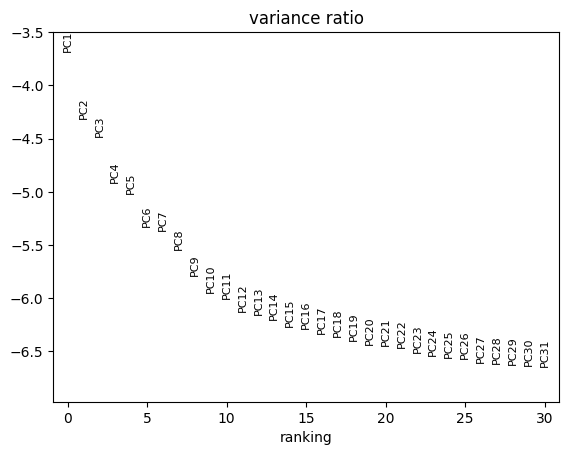

In [11]:
sc.pl.pca_variance_ratio(adata_hc, log=True)  # Scree plot of variance per PC  

In [12]:
# Build the neighborhood graph (15 neighbors, using the top 50 PCs)
sc.pp.neighbors(
    adata_hc,
    n_neighbors=15,
    n_pcs=50
)

# Run Leiden clustering at a moderate resolution (tune resolution as needed)
sc.tl.leiden(
    adata_hc,
    resolution=0.8,
    key_added='leiden'
)

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Roulis_Lab\AppData\Local\Temp\ipykernel_24284\474568456.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


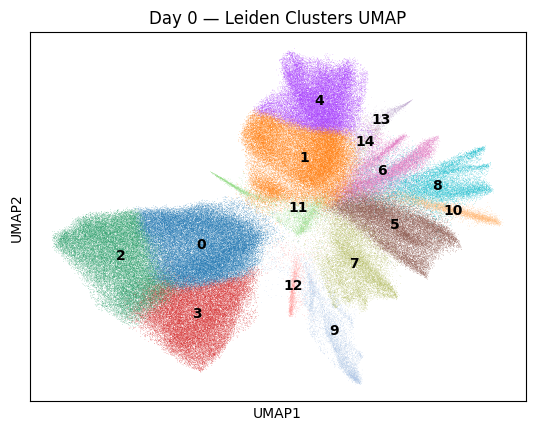

In [13]:
sc.tl.umap(adata_hc)
sc.pl.umap(adata_hc, color='leiden', title='Day 0 — Leiden Clusters UMAP', legend_loc='on data')

C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\Roulis_Lab\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2

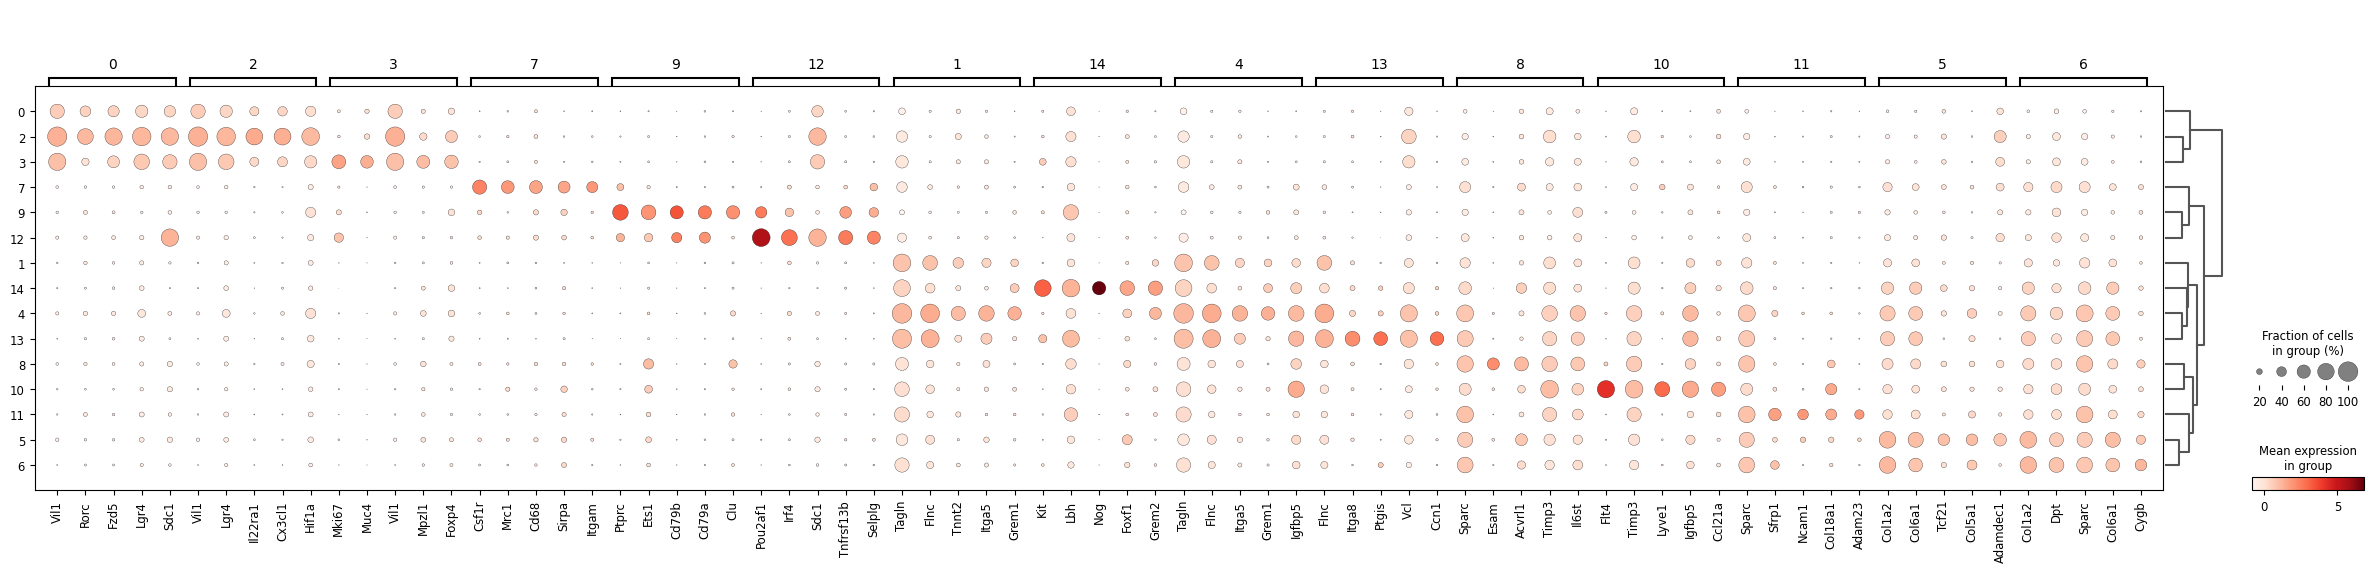

In [14]:
# Rank marker genes per cluster (Wilcoxon test)
sc.tl.rank_genes_groups(
    adata_hc,
    groupby='leiden',
    method='wilcoxon'
)

# Visualize top markers for each cluster
sc.pl.rank_genes_groups_dotplot(
    adata_hc,
    n_genes=5,
    groupby='leiden'
)

In [36]:
# Cell types
cell_types = {
    "Tier1": list(adata_hc.obs['Tier1'].unique()) + ["" for _ in range(len(adata_hc.obs['Tier3'].unique()) - len(adata_hc.obs['Tier1'].unique()))],
    "Tier2": list(adata_hc.obs['Tier2'].unique()) + ["" for _ in range(len(adata_hc.obs['Tier3'].unique()) - len(adata_hc.obs['Tier2'].unique()))],
    "Tier3": list(adata_hc.obs['Tier3'].unique())
}

celltypes_by_tier = pd.DataFrame(cell_types)
celltypes_by_tier.head()
# save celltypes_by_tier to csv
celltypes_by_tier.to_csv("celltypes_by_tier.csv", index=False)

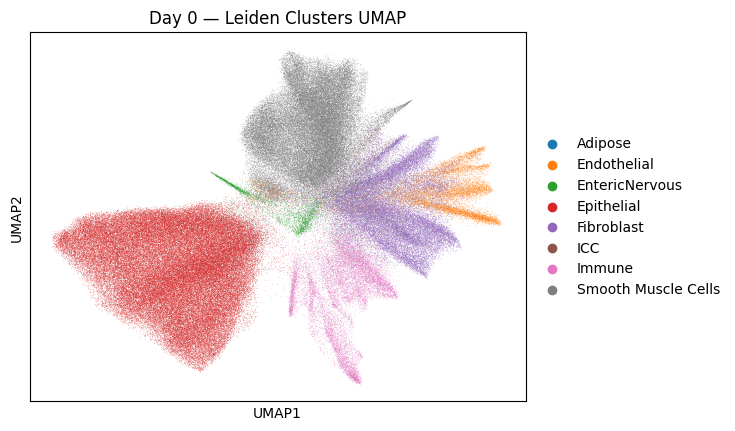

In [17]:
sc.pl.umap(adata_hc, color='Tier1', title='Day 0 — Leiden Clusters UMAP', legend_loc='right margin')

In [63]:
print(adata_hc)

AnnData object with n_obs × n_vars = 239450 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'Tier1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [56]:
# Define four anchor colors
colors = ["blue", "green", "yellow", "red"]

custom_cmap = LinearSegmentedColormap.from_list(
    "BlueGreenYellowRed",
    colors,     
    N=256  
)

output_dir = "Feature Plots"
os.makedirs(output_dir, exist_ok=True)

# marker dictionary
celltype_markers = {
    "Epithelial":       ["Cdh1","Epcam","Alpi","Muc2","Vil1","Lyz1","Lgr5","Olfm4","Ccnd1", "Adamdec1", "Wnt5a", "Bmp2", "Bmp5", "Bmp7"],
    "PanImmune":        ["Ptprc"],
    "BCell":            ["Ms4a1","Cd19"],
    "PlasmaCell":       ["Mzb1","Ccr10","Sdc1"],
    "TCell":            ["Cd3e"],
    "CD4_TCell":        ["Cd4"],
    "CD8_TCell":        ["Cd8a","Cd8b"],
    "NKCell":           ["Nkg7","Ncam1"],
    "Myeloid":          ["Cd68","Cd74"],
    "Monocyte_Mac":     ["Cd14", "Egr1", "Fos", "Nr4a1"],
    "Dendritic":        ["Itgax"],
    "MastCell":         ["Kit","Il1rl1"],
    "Treg":             ["Foxp3"],
    "Endothelial":      ["Pecam1"],
    "Lymphatic_Endo":   ["Lyve1", "Ccl21a"],
    "EntericNervous":   ["Tubb3", "Nos1"],
    "Adipose":          ["Fabp4"],
    "ICC":              ["Kit","Ano2"],
    "Glial":            ["Plp1","S100b", "Gfap", "Apod"],
    "Pericyte":         ["Rgs5","Pdgfrb","Adipoq", "Jam2", "Ngf", "Gdf10"],
    "SMC":              ["Myh11","Actg2","Myocd","Des","Acta2", "Tagln"],
    "Fibroblast":       ["Pdgfra","Sparc","Dcn","Lum","Col1a1", "Col1a2", "Col14a1","Fgfr2",
                         "Col3a1","Col4a5","Col4a6","Bmp5","Bmp4","Grem1","Vcam1",
                         "Ogn","Mgp","Sfrp2","C3","Dpt", "Col15a1","Cd34","Pi16","Ackr4","Col18a1","Mmp3","Mmp10","Mmp13","Plau","Il11"]
}

# Loop and plot
for celltype, genes in celltype_markers.items():
    for gene in genes:
        if gene not in adata_hc.var_names:
            print(f"Warning: {gene} not found in adata_hc; skipping.")
            continue
        # Plot UMAP for that gene
        fig = sc.pl.umap(
            adata_hc,
            color=gene,
            cmap=custom_cmap,
            size=1,
            alpha=1,
            vmin=0,
            vmax="p99",
            title=f"UMAP — {celltype} {gene}",
            show=False, # do not display interactively
            return_fig=True
        )
        # Save figure
        filename = f"{celltype}_{gene}.png"
        filepath = os.path.join(output_dir, filename)
        fig.savefig(filepath, dpi=150, bbox_inches='tight') 
        plt.close(fig)

# Compute Spatial Neighborhoods

In [66]:
# Build spatial neighborhood graph using Squidpy
adata_hc.obsm['spatial'] = adata_hc.obs[['x', 'y']].values
sq.gr.spatial_neighbors(
    adata_hc,
    coord_type="generic",        # general xy coordinates
    delaunay=True                # use Delaunay triangulation for adjacency
)
# This generates adata_hc.obsp['spatial_connectivities'] and distances

# Combine the expression and spatial adjacency matrices
expr = adata_hc.obsp['connectivities']
spatial = adata_hc.obsp['spatial_connectivities']

# normalize and weight
expr = expr / expr.max()
spatial = spatial / spatial.max()

combined = expr.multiply(0.5) + spatial.multiply(0.5)
adata_hc.obsp['combined_connectivities'] = combined

In [ ]:
# Leiden clustering on combined graph, defines tissue neighborhoods
combined = adata_hc.obsp['combined_connectivities']
sc.tl.leiden(
    adata_hc,
    adjacency=combined,
    resolution=0.5,
    key_added='tissue_neighborhood'
)


In [73]:
adata_hc.obsp['old_connectivities'] = adata_hc.obsp['connectivities']
adata_hc.obsp['old_distances']     = adata_hc.obsp['distances']

adata_hc.obsp['connectivities'] = adata_hc.obsp['combined_connectivities']
adata_hc.obsp['distances']      = adata_hc.obsp.get('combined_distances',
                                                       adata_hc.obsp['combined_connectivities'])

sc.tl.umap(adata_hc)
adata_hc.obsm['X_umap_neighborhood'] = adata_hc.obsm['X_umap'].copy()

adata_hc.obsp['connectivities'] = adata_hc.obsp['old_connectivities']
adata_hc.obsp['distances']      = adata_hc.obsp['old_distances']
del adata_hc.obsp['old_connectivities'], adata_hc.obsp['old_distances']

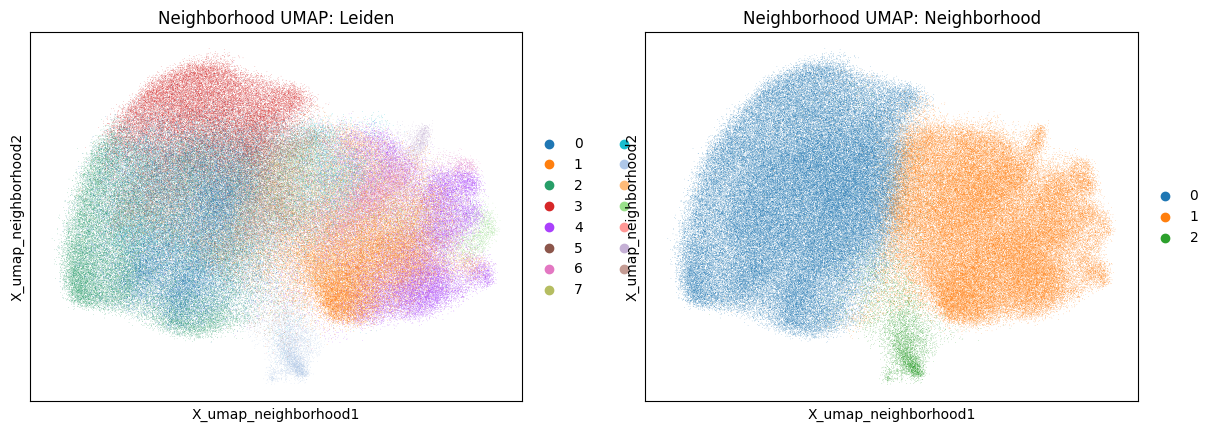

In [85]:
# neighborhood-informed UMAP
sc.pl.embedding(adata_hc,
                basis='X_umap_neighborhood',
                color=['leiden','tissue_neighborhood'],
                title=['Neighborhood UMAP: Leiden','Neighborhood UMAP: Neighborhood'],
                ncols=2)


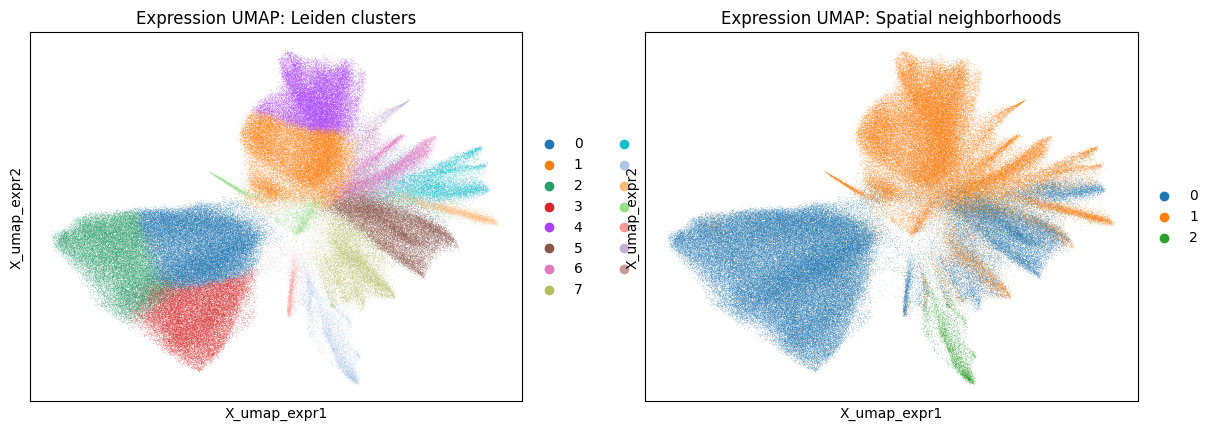

In [86]:
# Re-build the expression‑only kNN graph 
sc.pp.neighbors(adata_hc, n_neighbors=15, n_pcs=50)

# Compute UMAP embedding (expression‑only) 
sc.tl.umap(adata_hc, min_dist=0.5, spread=1.0)

# Save the expression UMAP in a separate obsm key
adata_hc.obsm["X_umap_expr"] = adata_hc.obsm["X_umap"].copy()

# Plot expression UMAP (clusters + neighborhoods) side-by-side
sc.pl.embedding(
    adata_hc,
    basis="X_umap_expr",
    color=["leiden", "tissue_neighborhood"],
    title=["Expression UMAP: Leiden clusters", "Expression UMAP: Spatial neighborhoods"],
    ncols=2
)

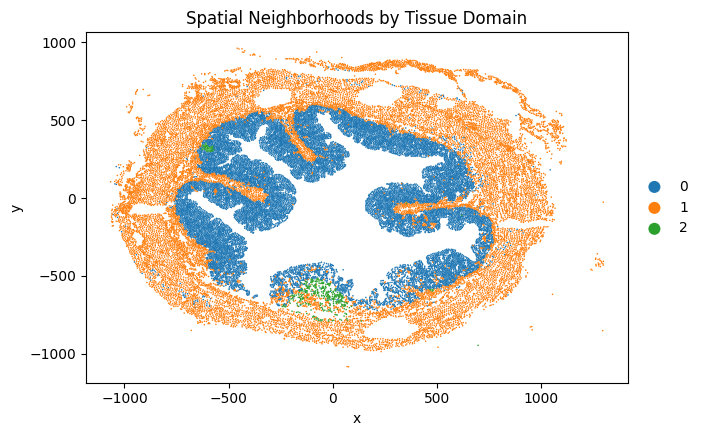

In [96]:
# Plot physical spatial map of tissue neighborhoods
# select slice for spatial plot
slice = adata_hc.obs['Slice_ID'].unique()[0]
adata_hc_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice].copy()
x = adata_hc_slice.obs['x']
y = adata_hc_slice.obs['y']

sc.pl.scatter(
    adata_hc_slice,
    x='x',
    y='y',
    color='tissue_neighborhood',
    size=5,
    alpha=1,
    title='Spatial Neighborhoods by Tissue Domain',
    legend_loc='right margin'
)